In [2]:
import sys; sys.path.append('../')
import numpy as np
from partition_decode.dataset import generate_gaussian_parity, recursive_gaussian_parity, generate_spirals, load_mnist
from partition_decode.df_utils import get_tree_evals, get_forest_evals, get_forest_irm, get_tree_irm
from partition_decode.models import ReluNetClassifier
from partition_decode.metrics import irm2activations, score_matrix_representation, fast_evals
import torch
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import zero_one_loss, log_loss

In [6]:
def hidden_to_params(h, k=2, d=2):
    return (d+1) * h + (h+1) * k

def get_units_at_interp(n, k=2, d=2):
    # n k = (d+1) H + (H+1) K
    return np.ceil((n * k - k) / (d + 2)).astype(int)

In [9]:
def get_eigenval_metrics(irm):
    metric_params = [
        {'metric': 'norm', 'p': 1},
        {'metric': 'norm', 'p': 2},
        {'metric': 'n_regions'},
        {'metric': 'norm', 'p': 2, 'regions': True},
        {'metric': 'h*'},
        {'metric': 'h*', 'regions': True},
        {'metric': 'entropy'},
        {'metric': 'row_means', 'p': 2},
        {'metric': 'col_means', 'p': 1},
        {'metric': 'col_means', 'p': 2},
    ]

    # Prune columns that are the same
    irm = irm[:, ~np.all(irm[1:] == irm[:-1], axis=0)]

    metrics = []
    evals = fast_evals(irm)
    for params in metric_params:
        if params['metric'] in ['norm', 'h*', 'entropy'] and (
            'regions' not in list(params.keys())
        ):
            metrics.append(
                score_matrix_representation(evals, is_evals=True, **params)
            )
        else:
            metrics.append(
                score_matrix_representation(irm, **params)
            )
    return metrics

def run_network(X_train, y_train, X_test, model_params, model):
    model = ReluNetClassifier(**model_params)

    model.fit(X_train, y_train)
    y_train_pred = model.predict_proba(X_train)
    y_test_pred = model.predict_proba(X_test)

    irm = model.get_internal_representation(X_train, penultimate=False)

    model_metrics = get_eigenval_metrics(irm)
    model_metrics += [
        model.n_parameters_, len(model.hidden_layer_dims),
        model.hidden_layer_dims[0]
        ]

    return model, y_train_pred, y_test_pred, model_metrics


def get_y_metrics(y_true, y_pred):
    errors = [
        zero_one_loss(y_true, y_pred.argmax(1)),
        np.linalg.norm(1 - y_pred[:, y_true]) / len(y_true)
    ]
    return errors

## Load MNIST

In [215]:
from torchvision import datasets, transforms

n_train = 4000

train_set = datasets.MNIST('/mnt/ssd3/ronan/pytorch', train=True, download=True)
X_train = train_set.data.numpy()[:n_train]
X_train = X_train.reshape((n_train, -1))
y_train = train_set.targets.numpy()[:n_train]
del train_set

test_set = datasets.MNIST('/mnt/ssd3/ronan/pytorch', train=False, download=True)
X_test = test_set.data.numpy()
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = test_set.targets.numpy()

In [216]:
n_hidden = get_units_at_interp(n_train, k=len(np.unique(y_train)), d=X_train.shape[-1])
print(f'{n_hidden} hidden units')

51 hidden units


In [219]:
results = [[
    'hidden_layer_dims',
    'train_01_error',
    'train_mse',
    'test_01_error',
    'test_mse',   
] + [
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2', 'IRM_h*', 'ACTS_h*', 'entropy',
    'rows_mean_L2', 'cols_mean_L1', 'cols_mean_L2'
] + [
    'n_parameters', 'depth', 'width'
]]

NETWORK_PARAMS = {
    'hidden_layer_dims': [
        [4],
        [8],
        [16],
        [32],
        [40],
        [45],
        [47],
        [51],
        [55],
        [60],
        [100]
    ],
    'n_epochs': [500],# [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],# 2048],
    'learning_rate': [1e-5],
    'batch_size': [128],
    'verbose': [0],
    'early_stop_thresh': [0],
    "bias": [True],
    # "loss": [torch.nn.MSELoss],
}

In [220]:
keys, values = zip(*NETWORK_PARAMS.items())
model_params_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

model = None
for model_params in tqdm(model_params_grid):
    # Train and test model
    model, y_train_pred, y_test_pred, model_metrics = run_network(
        X_train, y_train, X_test, model_params, model
    )

    # Compute metrics
    results += [
        [model_params['hidden_layer_dims'][0]]
        + get_y_metrics(y_train, y_train_pred)  # Train
        + get_y_metrics(y_test, y_test_pred)  # Test
        + model_metrics
    ]

  0%|          | 0/11 [00:00<?, ?it/s]/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████| 11/11 [04:58<00:00, 27.14s/it]


In [221]:
df = pd.DataFrame(results[1:], columns=results[0])

In [222]:
df

,hidden_layer_dims,train_01_error,train_mse,test_01_error,test_mse,IRM_L1,IRM_L2,n_regions,ACTS_L2,IRM_h*,ACTS_h*,entropy,rows_mean_L2,cols_mean_L1,cols_mean_L2,n_parameters,depth,width
0,4,0.89875,0.900858,0.9042,0.900973,0.0,0.000000,1,4000.000000,0,1,0.000000,0.000000,NaN,NaN,3190,1,4
1,8,0.80325,0.904023,0.8012,0.903720,399.0,399.000000,2,3623.037676,1,2,2389.595605,0.099750,399.000000,19.974984,6370,1,8
2,16,0.70575,0.907917,0.7045,0.908213,1021.0,751.210357,14,3083.293045,9,14,6289.320281,0.187790,113.444444,3.602126,12730,1,16
3,32,0.24075,0.929540,0.2978,0.929293,5199.0,1823.520496,276,1196.600184,31,276,31664.057314,0.420941,167.709677,3.361501,25450,1,32
4,40,0.21675,0.935260,0.3170,0.933793,8224.0,2989.161755,507,836.669588,38,507,53364.307118,0.661154,216.421053,3.953329,31810,1,40
5,45,0.10825,0.941258,0.2293,0.939919,10361.0,2806.618428,1156,523.656376,44,1156,64167.834298,0.581404,235.477273,4.431235,35785,1,45
6,47,0.08400,0.941890,0.2029,0.940777,12862.0,3893.759880,1250,348.146521,45,1250,84509.718605,0.748343,285.822222,5.111401,37375,1,47
7,51,0.09775,0.941653,0.2071,0.940476,11052.0,2888.545309,1315,387.499677,51,1315,68053.643611,0.596324,216.705882,3.987582,40555,1,51
8,55,0.09925,0.941591,0.2402,0.939759,11527.0,3131.184919,1275,351.621956,54,1275,72275.567834,0.632384,213.462963,3.858212,43735,1,55
9,60,0.05700,0.943994,0.2040,0.942454,15823.0,4292.620062,2071,236.976792,60,2071,102645.711217,0.797670,263.716667,4.651851,47710,1,60


In [239]:
train_error = 'train_01_error'
test_error = 'test_01_error'

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]

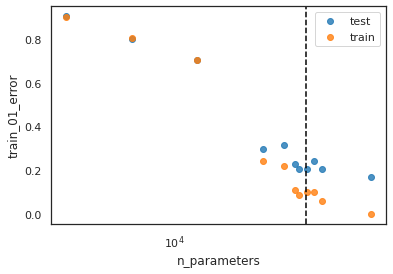

In [240]:
sns.set_style('white')
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, sharex=True)

sns.regplot(data=df, x='n_parameters', y=test_error, lowess=False, ax=ax, label='test', fit_reg=False)
sns.regplot(data=df, x='n_parameters', y=train_error, lowess=False, ax=ax, label='train', fit_reg=False)
# sns.regplot(data=df, x='n_parameters', y='generalization_gap', lowess=False, ax=ax, label='gen_gap')

ax.axvline(len(np.unique(y_train))*n_train, ls='--', c='black')
plt.xscale('log')
# plt.yscale('symlog')
plt.legend()
plt.show()

In [236]:
corr_vars = [
    'generalization_gap',
    'n_parameters', 'depth', 'width', # 'n_epochs',
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2',
    'IRM_h*', 'ACTS_h*', 'entropy',
    'rows_mean_L2',
    'cols_mean_L1', 'cols_mean_L2',
]

corr_df = df[corr_vars].corr('kendall')
display(corr_df)

,generalization_gap,n_parameters,depth,width,IRM_L1,IRM_L2,n_regions,ACTS_L2,IRM_h*,ACTS_h*,entropy,rows_mean_L2,cols_mean_L1,cols_mean_L2
generalization_gap,1.000000,0.818182,NaN,0.818182,0.818182,0.745455,0.781818,-0.818182,0.818182,0.418182,0.818182,0.709091,0.377778,0.288889
n_parameters,0.818182,1.000000,NaN,1.000000,0.927273,0.854545,0.963636,-0.927273,1.000000,0.600000,0.927273,0.818182,0.333333,0.244444
depth,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
width,0.818182,1.000000,NaN,1.000000,0.927273,0.854545,0.963636,-0.927273,1.000000,0.600000,0.927273,0.818182,0.333333,0.244444
IRM_L1,0.818182,0.927273,NaN,0.927273,1.000000,0.927273,0.890909,-1.000000,0.927273,0.527273,1.000000,0.890909,0.422222,0.333333
IRM_L2,0.745455,0.854545,NaN,0.854545,0.927273,1.000000,0.818182,-0.927273,0.854545,0.454545,0.927273,0.963636,0.333333,0.244444
n_regions,0.781818,0.963636,NaN,0.963636,0.890909,0.818182,1.000000,-0.890909,0.963636,0.636364,0.890909,0.781818,0.377778,0.288889
ACTS_L2,-0.818182,-0.927273,NaN,-0.927273,-1.000000,-0.927273,-0.890909,1.000000,-0.927273,-0.527273,-1.000000,-0.890909,-0.422222,-0.333333
IRM_h*,0.818182,1.000000,NaN,1.000000,0.927273,0.854545,0.963636,-0.927273,1.000000,0.600000,0.927273,0.818182,0.333333,0.244444
ACTS_h*,0.418182,0.600000,NaN,0.600000,0.527273,0.454545,0.636364,-0.527273,0.600000,1.000000,0.527273,0.418182,-0.022222,-0.022222


## XOR

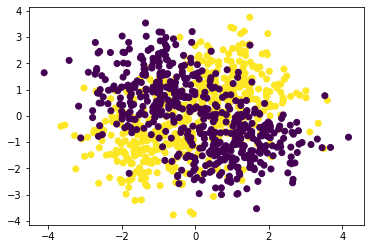

In [12]:
n_train = 1024

X_train, y_train = generate_gaussian_parity(
    n_samples=n_train, angle_params=0, random_state=0, cov_scale=1
)

X_test, y_test = generate_gaussian_parity(
    n_samples=10000, angle_params=0, random_state=1234, cov_scale=1
)

import matplotlib.pyplot as plt
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

In [13]:
n_hidden = get_units_at_interp(n_train, k=len(np.unique(y_train)), d=X_train.shape[-1])
print(f'{n_hidden} hidden units')

512 hidden units


In [14]:
results = [[
    'hidden_layer_dims',
    'train_01_error',
    'train_mse',
    'test_01_error',
    'test_mse',   
] + [
    'IRM_L1', 'IRM_L2', 'n_regions', 'ACTS_L2', 'IRM_h*', 'ACTS_h*', 'entropy',
    'rows_mean_L2', 'cols_mean_L1', 'cols_mean_L2'
] + [
    'n_parameters', 'depth', 'width'
]]

NETWORK_PARAMS = {
    'hidden_layer_dims': [
        [100],
        [300],
        [450],
        [500],
        [512],
        [550],
        [600],
        [1000]
    ],
    'n_epochs': [1000],# [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],# 2048],
    'learning_rate': [1e-5],
    'batch_size': [128],
    'verbose': [0],
    'early_stop_thresh': [0],
    "bias": [True],
    # "loss": [torch.nn.MSELoss],
}

In [15]:
keys, values = zip(*NETWORK_PARAMS.items())
model_params_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

model = None
for model_params in tqdm(model_params_grid):
    # Train and test model
    model, y_train_pred, y_test_pred, model_metrics = run_network(
        X_train, y_train, X_test, model_params, model
    )

    # Compute metrics
    results += [
        [model_params['hidden_layer_dims'][0]]
        + get_y_metrics(y_train, y_train_pred)  # Train
        + get_y_metrics(y_test, y_test_pred)  # Test
        + model_metrics
    ]

100%|██████████| 8/8 [02:09<00:00, 16.16s/it]


In [16]:
df = pd.DataFrame(results[1:], columns=results[0])

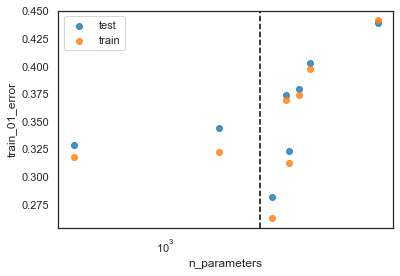

In [17]:
train_error = 'train_01_error'
test_error = 'test_01_error'

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]

sns.set_style('white')
sns.set_context('notebook')

fig, ax = plt.subplots(1, 1, sharex=True)

sns.regplot(data=df, x='n_parameters', y=test_error, lowess=False, ax=ax, label='test', fit_reg=False)
sns.regplot(data=df, x='n_parameters', y=train_error, lowess=False, ax=ax, label='train', fit_reg=False)
# sns.regplot(data=df, x='n_parameters', y='generalization_gap', lowess=False, ax=ax, label='gen_gap')

ax.axvline(len(np.unique(y_train))*n_train, ls='--', c='black')
plt.xscale('log')
# plt.yscale('symlog')
plt.legend()
plt.show()